# Lab - 5: Multiclass Multilabel Classification

### Lab Objective

The objective of this lab is to understand and implement multiclass multilabel classification using transfer learning with a pre-trained ResNet model.

### Dataset information
We use birds images for image classification.
Dataset link: https://data.caltech.edu/records/65de6-vp158

### Classes
1. 001.Black_footed_Albatross
2. 002.Laysan_Albatross
3. 003.Sooty_Albatross
4. 004.Groove_billed_Ani
5. 005.Crested_Auklet
6. 006.Least_Auklet
7. 007.Parakeet_Auklet
8. 008.Rhinoceros_Auklet
9. 009.Brewer_Blackbird
10. 010.Red_winged_Blackbird

We use 10 classes for this lab

###  Tasks
1. **Setup and Data Preparation**

    - Set up the working environment
    - Install required dependencies
    - Download and explore the dataset
    - Create data loaders and apply necessary transformations

2. **Understanding Pre-trained Models**

    - Load ResNet pre-trained on ImageNet
    - Explore model architecture and parameters
    - Visualize and understand feature maps from different layers
    - Run inference using the pre-trained model without fine-tuning

3. **Training and Evaluation**

    - Implement the training loop with proper loss function and optimizer
    - Monitor training progress
    - Visualize results and model predictions

### What is transfer learning?

- Transfer learning is a machine learning technique where a model trained on one task is repurposed as the foundation for a second task. This approach is beneficial when the second task is related to the first or when data for the second task is limited. Leveraging learned features from the initial task, the model can adapt more efficiently to the new task, accelerating learning and improving performance. Transfer learning also reduces overfitting risk, as the model already incorporates generalizable features useful for the second task.

### Why is Transfer Learning Important?
- Limited Data: Acquiring extensive labeled data is often challenging and costly. Transfer learning enables us to use pre-trained models, reducing the dependency on large datasets.
- Enhanced Performance: Starting with a pre-trained model, which has already learned from substantial data, allows for faster and more accurate results on new tasks—ideal for applications needing high accuracy and efficiency.
- Time and Cost Efficiency: Transfer learning shortens training time and conserves resources by utilizing existing models, eliminating the need for training from scratch.
- Adaptability: Models trained on one task can be fine-tuned for related tasks, making transfer learning versatile for various applications, from image recognition to natural language processing.

### Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### Data trasformation and preprocessing

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


### Loading dataset from folder

In [4]:
data_dir = 'CUB_subset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird']


In [5]:
device

device(type='cuda', index=0)

### Sample Data

In [6]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

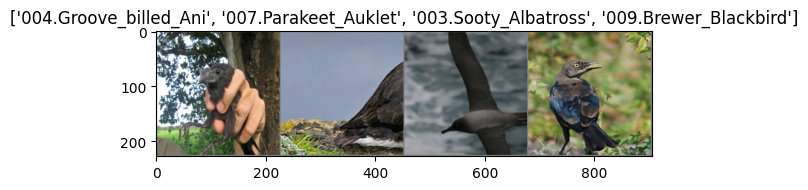

In [7]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Loading pre-train ResNet model

In [8]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

d:\Nokia_DL_L3_lab\nokia\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Nokia_DL_L3_lab\nokia\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training loop

In [10]:
def train_model(model, criterion, optimizer, num_epochs=25):
    train_loss = []
    validation_loss = []
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Training Phase
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over training data
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # scheduler.step()

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        
        train_loss.append(epoch_loss)

        print('Training Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print()

        # Validation Phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over validation data
        with torch.no_grad():
            for inputs, labels in dataloaders['valid']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / dataset_sizes['valid']
        val_acc = running_corrects.double() / dataset_sizes['valid']

        validation_loss.append(val_loss)
        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, train_loss, validation_loss

### Training model

In [11]:
model, train_loss, val_loss = train_model(model, criterion, optimizer, num_epochs=25)


Epoch 0/24
----------
Training Loss: 2.0512 Acc: 0.2857

Validation Loss: 1.3425 Acc: 0.4815
Epoch 1/24
----------
Training Loss: 1.6227 Acc: 0.4632

Validation Loss: 1.2497 Acc: 0.5370
Epoch 2/24
----------
Training Loss: 1.3026 Acc: 0.5952

Validation Loss: 0.8344 Acc: 0.7222
Epoch 3/24
----------
Training Loss: 1.2510 Acc: 0.5844

Validation Loss: 0.7941 Acc: 0.7037
Epoch 4/24
----------
Training Loss: 1.1572 Acc: 0.6255

Validation Loss: 0.9477 Acc: 0.6667
Epoch 5/24
----------
Training Loss: 1.1287 Acc: 0.6385

Validation Loss: 0.7694 Acc: 0.7222
Epoch 6/24
----------
Training Loss: 1.0702 Acc: 0.6667

Validation Loss: 0.6173 Acc: 0.7963
Epoch 7/24
----------
Training Loss: 1.1271 Acc: 0.6126

Validation Loss: 0.7296 Acc: 0.7593
Epoch 8/24
----------
Training Loss: 0.9104 Acc: 0.7056

Validation Loss: 0.7089 Acc: 0.7407
Epoch 9/24
----------
Training Loss: 1.0083 Acc: 0.6494

Validation Loss: 0.5965 Acc: 0.8148
Epoch 10/24
----------
Training Loss: 1.0107 Acc: 0.6494

Validation L

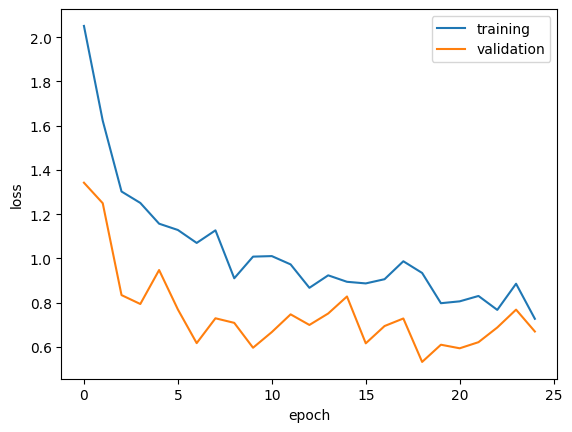

In [12]:
plt.figure()
plt.plot(np.arange(25), train_loss)
plt.plot(np.arange(25), val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [13]:
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])

dataloaders = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

In [14]:
len(test_dataset)

22

In [15]:
def predict_img(img, model):
    # data, target = data.to(device), target.to(device)
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    
    _, pred = torch.max(yb, dim=1)
    return pred    

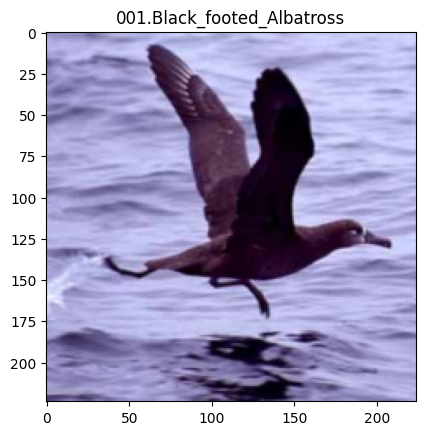

Label: 001.Black_footed_Albatross , Predicted: 001.Black_footed_Albatross


In [23]:
img, label = test_dataset[0]
imshow(img, class_names[label])
print('Label:', class_names[label], ', Predicted:', class_names[predict_img(img, model).item()])

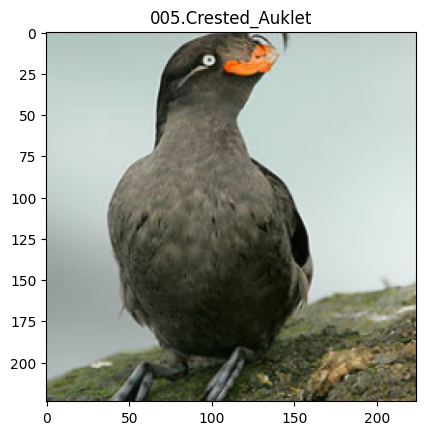

Label: 005.Crested_Auklet , Predicted: 005.Crested_Auklet


In [24]:
img, label = test_dataset[10]
imshow(img, class_names[label])
print('Label:', class_names[label], ', Predicted:', class_names[predict_img(img, model).item()])

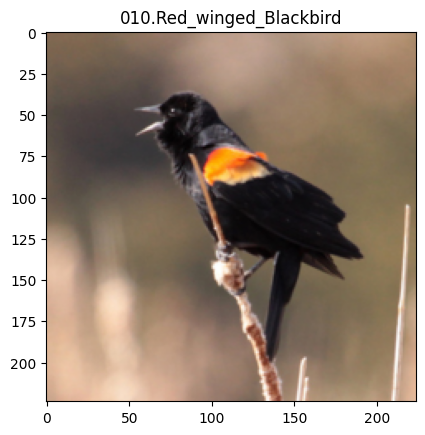

Label: 010.Red_winged_Blackbird , Predicted: 010.Red_winged_Blackbird


In [25]:
img, label = test_dataset[21]
imshow(img, class_names[label])
print('Label:', class_names[label], ', Predicted:', class_names[predict_img(img, model).item()])